In [293]:
"""
* 머신러닝 목표
    : '회원 활동 및 상태 변화 데이터(2022년 9월) → 회원 상태가 언제 만료(44)로 변화할 지 예측

* 머신러닝 진행 과정

1. 탐색적 데이터 분석(EDA) 및 데이터 전처리
    1) 데이터 요약 
        - 결측값 확인 및 처리
    2) 데이터 분포 확인
        - 시각화_누적막대그래프 : user 별 event_type 누적 count
    3) 데이터 전처리
    - userid -> userid_simple 로 간소화
    - 새로운 피처 생성
        - days_between_mean : user 별 평균 접속일 간격
        - days_between_slope : user 별 접속일 간격 기울기(접속일 간격의 증감 추이)
        - mcode_count : user별 이용 학습 컨텐츠 총 합
    - 변수 변환
        - 피처 3개 분포 확인(histogram) -> 로그 변환 -> minmax sacling(0~1)
2. 모델 학습 및 성능평가
    - 독립변수 / 종속변수 정의
    - 종속변수 오버샘플링
    - 모델학습 (선형 회귀, 랜덤 포레스트 회귀, 서포트 벡터 회귀) 및 성능 평가
    - Feature 별 중요도 분석
    - 성능평가 (Root Mean Square Error(RMSE), Residual Plot, Learning Curve)
3. 모델 성능 요약 및 비교
"""

"\n* 머신러닝 목표\n    : '회원 활동 및 상태 변화 데이터(2022년 9월) → 회원 상태가 언제 만료(44)로 변화할 지 예측\n\n* 머신러닝 진행 과정\n\n1. 탐색적 데이터 분석(EDA) 및 데이터 전처리\n    1) 데이터 요약 \n        - 결측값 확인 및 처리\n    2) 데이터 분포 확인\n        - 시각화_누적막대그래프 : user 별 event_type 누적 count\n    3) 데이터 전처리\n    - userid -> userid_simple 로 간소화\n    - 새로운 피처 생성\n        - days_between_mean : user 별 평균 접속일 간격\n        - days_between_slope : user 별 접속일 간격 기울기(접속일 간격의 증감 추이)\n        - mcode_count : user별 이용 학습 컨텐츠 총 합\n    - 변수 변환\n        - 피처 3개 분포 확인(histogram) -> 로그 변환 -> minmax sacling(0~1)\n2. 모델 학습 및 성능평가\n    - 독립변수 / 종속변수 정의\n    - 종속변수 오버샘플링\n    - 모델학습 (선형 회귀, 랜덤 포레스트 회귀, 서포트 벡터 회귀) 및 성능 평가\n    - Feature 별 중요도 분석\n    - 성능평가 (Root Mean Square Error(RMSE), Residual Plot, Learning Curve)\n3. 모델 성능 요약 및 비교\n"

In [294]:
# 패키지 함수 임포트
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, mean_absolute_error, accuracy_score,confusion_matrix, roc_curve, auc,  mean_squared_error, r2_score
import matplotlib.font_manager as fm
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, DecisionTreeClassifier
from sklearn.svm import SVC, SVR
import shap
import re

# 부호 사용시, 사용할 글꼴 설정
plt.rcParams["font.family"] = "DejaVu Sans"

In [295]:
# 데이터 프레임 생성
df = pd.read_excel("Data/activity_sample.xlsx", index_col=0)
df.head(3)

,userid,learning_seq,mcode,learning_action_seq,event_type,action,object_type,timestamp,gender,grade,...,day_23_status,day_24_status,day_25_status,day_26_status,day_27_status,day_28_status,day_29_status,day_30_status,day_31_status,change_date
6338,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,1,ViewEvent,Viewed,DigitalResource,2022-09-14 23:28:53.150,M,5,...,11,11,44,44,44,44,44,44,999,25
6339,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,2,NavigationEvent,NavigatedTo,DigitalResource,2022-09-14 23:30:09.481,M,5,...,11,11,44,44,44,44,44,44,999,25
6340,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,3,ViewEvent,Viewed,DigitalResource,2022-09-14 23:30:09.604,M,5,...,11,11,44,44,44,44,44,44,999,25


In [296]:
# 메타 데이터
# 고유값이 하나이거나 회원상태에 영향이 미미하다고 판단한 변수는 제외함
"""
- userid : 회원 고유 id
- learning_seq(학습 순서) = mcode : 콘텐츠 고유 id
- event type : 이벤트 유형
- action : 이벤트에 포함되는 행동 내용
- object_type : 활동 대상
- timestamp : 해당 학습 중 행동이 발생한 시간
- memnerstatus_change : 월 중 회원상태 변화
- day_01~31_status : 01~31일 회원상태
- change_date : 44로 상태변화한 day  
- duration : user 별 시청 지속 시간(start timestamp - end timestamp)
- userid_simple : 회원 고유 id 를 user00 으로 나타냄
"""
"""
- userid : 회원 고유 id
- learning_seq(학습 순서) = mcode : 콘텐츠 고유 id
- event_type : 이벤트 유형
    - 'ViewEvent('Viewed')' 'NavigationEvent('NavigatedTo')' 'MediaEvent('Started' 'JumpedTo' 'Ended' 'ChangedVolume' 'Restarted' 'ChangedSpeed' 'Paused' 'Resumed')'
- action : 이벤트에 포함되는 행동 내용
    - 'Viewed' 'NavigatedTo' 'Started' 'JumpedTo' 'Ended' 'ChangedVolume' 'Restarted' 'ChangedSpeed' 'Paused' 'Resumed'
- object_type : 활동 대상
    - 'DigitalResource' 'VideoObject' 'WebPage'
- timestamp : 해당 학습 중 행동이 발생한 시간
    - action 이 발생한 특정 시점
- memnerstatus_change : 월 중 회원상태 변화 (마지막은 모두 44)
    * - : 결측치  / 0 : 대기  / 1 : 준회원(무료체험)   / 2 : 일반    / 11 : 정회원    / 44 : 만료    / 55 : 정회원(이월)
    - 00,11,44
- day_01~31_status : 01~31일 회원상태
- change_date : 44로 상태변화한 day
"""

"\n- userid : 회원 고유 id\n- learning_seq(학습 순서) = mcode : 콘텐츠 고유 id\n- event_type : 이벤트 유형\n    - 'ViewEvent('Viewed')' 'NavigationEvent('NavigatedTo')' 'MediaEvent('Started' 'JumpedTo' 'Ended' 'ChangedVolume' 'Restarted' 'ChangedSpeed' 'Paused' 'Resumed')'\n- action : 이벤트에 포함되는 행동 내용\n    - 'Viewed' 'NavigatedTo' 'Started' 'JumpedTo' 'Ended' 'ChangedVolume' 'Restarted' 'ChangedSpeed' 'Paused' 'Resumed'\n- object_type : 활동 대상\n    - 'DigitalResource' 'VideoObject' 'WebPage'\n- timestamp : 해당 학습 중 행동이 발생한 시간\n    - action 이 발생한 특정 시점\n- memnerstatus_change : 월 중 회원상태 변화 (마지막은 모두 44)\n    * - : 결측치  / 0 : 대기  / 1 : 준회원(무료체험)   / 2 : 일반    / 11 : 정회원    / 44 : 만료    / 55 : 정회원(이월)\n    - 00,11,44\n- day_01~31_status : 01~31일 회원상태\n- change_date : 44로 상태변화한 day\n"

In [297]:
print(df.shape)
print(df.columns)

(6476, 44)
Index(['userid', 'learning_seq', 'mcode', 'learning_action_seq', 'event_type',
       'action', 'object_type', 'timestamp', 'gender', 'grade', 'memberstatus',
       'memberstatus_change', 'day_01_status', 'day_02_status',
       'day_03_status', 'day_04_status', 'day_05_status', 'day_06_status',
       'day_07_status', 'day_08_status', 'day_09_status', 'day_10_status',
       'day_11_status', 'day_12_status', 'day_13_status', 'day_14_status',
       'day_15_status', 'day_16_status', 'day_17_status', 'day_18_status',
       'day_19_status', 'day_20_status', 'day_21_status', 'day_22_status',
       'day_23_status', 'day_24_status', 'day_25_status', 'day_26_status',
       'day_27_status', 'day_28_status', 'day_29_status', 'day_30_status',
       'day_31_status', 'change_date'],
      dtype='object')


In [298]:
# 컬럼 별 고유값 확인
unique_value_counts = {col: df[col].value_counts() for col in df.columns}

for col, value_counts in unique_value_counts.items():
    print(f"Column: {col}")
    print("Unique Values and Counts:")
    for value, count in value_counts.items():
        print(f" - {value} ({count})")
    print("\n")

Column: userid
Unique Values and Counts:
 - d62cce9e-39d7-439d-8476-f59473f05915 (782)
 - b3ddd47d-5c6f-44ba-9bd6-ff698a742f73 (571)
 - 4ef416c9-de60-499e-b971-a780e076991e (432)
 - f157a6f8-c680-42bf-8b48-03744367f7b1 (410)
 - c3a7d18e-2814-42e3-b35c-2ea488c4ed51 (389)
 - 943ee87d-d6d7-4ad4-b7dd-4ca171d8107e (324)
 - 909c25d9-64ef-4e4f-b47f-4df50f02c07f (323)
 - 91749c9e-af85-4f73-b252-2d05c04b508f (312)
 - 076bf224-16b8-48ca-b646-752a771b1dcc (306)
 - 4e478763-9937-4d47-b7da-a0113f860b52 (306)
 - 7aa6cf37-81af-4af8-a272-6a850e65e25c (285)
 - c25b0ef3-b6ed-4010-b8ca-b35e2293f8cb (202)
 - a9c80240-7734-401d-bddf-999d869e42a1 (198)
 - a3c0a30d-346f-4b58-967b-70ae79302871 (192)
 - d5871049-d107-4946-a7df-cea704f738ed (183)
 - a11ea25b-593c-45f4-8c68-8e97b489e53a (179)
 - 676a004e-7c59-4edb-8af1-3bd963b98b29 (167)
 - 2bd83b70-6085-48d1-8433-6bef1f4fa584 (167)
 - 5b531894-59c3-4cf3-8fa4-eb1836fbd6b3 (161)
 - b8be7534-636b-4304-b3b2-ced246c3c1eb (144)
 - 3a23c7e1-861a-41ce-a856-f16a4df5a5df

In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6476 entries, 6338 to 3085
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   userid               6476 non-null   object        
 1   learning_seq         6476 non-null   int64         
 2   mcode                6476 non-null   object        
 3   learning_action_seq  6476 non-null   int64         
 4   event_type           6476 non-null   object        
 5   action               6476 non-null   object        
 6   object_type          6476 non-null   object        
 7   timestamp            6476 non-null   datetime64[ns]
 8   gender               6476 non-null   object        
 9   grade                6476 non-null   int64         
 10  memberstatus         6476 non-null   int64         
 11  memberstatus_change  6476 non-null   object        
 12  day_01_status        6476 non-null   object        
 13  day_02_status        6476 non-null 

In [300]:
# 1. 탐색적 데이터 분석(EDA)

# 1) 데이터 요약

# 결측값 확인
print(df.isnull().sum())  # '-' 가 str 로 처리되어 확인불가

userid                 0
learning_seq           0
mcode                  0
learning_action_seq    0
event_type             0
action                 0
object_type            0
timestamp              0
gender                 0
grade                  0
memberstatus           0
memberstatus_change    0
day_01_status          0
day_02_status          0
day_03_status          0
day_04_status          0
day_05_status          0
day_06_status          0
day_07_status          0
day_08_status          0
day_09_status          0
day_10_status          0
day_11_status          0
day_12_status          0
day_13_status          0
day_14_status          0
day_15_status          0
day_16_status          0
day_17_status          0
day_18_status          0
day_19_status          0
day_20_status          0
day_21_status          0
day_22_status          0
day_23_status          0
day_24_status          0
day_25_status          0
day_26_status          0
day_27_status          0
day_28_status          0


In [301]:
# 결측값 처리

# day_01_status부터 day_31_status까지의 열 이름을 리스트로 생성
day_status_columns = [f"day_{i:02d}_status" for i in range(1, 32)]

# 해당 열들을 문자열로 변환
df[day_status_columns] = df[day_status_columns].astype(str)

# '-'가 포함된 샘플 수 확인 (day_status_columns에서)
contains_hyphen_day_status = df[day_status_columns].apply(lambda x: x.str.contains("-", regex=False)).any(axis=1).sum()
print(f"'-'를 포함한 샘플 수 (day_status_columns): {contains_hyphen_day_status}")

# '-'를 '0'으로 대체 (day_status_columns에서)
df[day_status_columns] = df[day_status_columns].replace("-", "0", regex=False)

# '-'를 '0'으로 대체한 후의 전체 샘플 수 확인 (day_status_columns)
after_cleanup_day_status = df.shape[0]
print(f"'-'를 '0'으로 대체한 후의 샘플 수 (day_status_columns): {after_cleanup_day_status}")


# "-"가 포함된 샘플 수 확인 (memberstatus_change에서)
contains_hyphen_memberstatus = df["memberstatus_change"].str.contains("-", regex=False).sum()
print(f"'-'를 포함했던 샘플 수 (memberstatus_change): {contains_hyphen_memberstatus}")

# "-"를 처리하는 함수 정의
def replace_hyphen(value):
    # 맨 앞에 있는 "-"를 "0"으로 대체
    value = re.sub(r"^-", "0", value)
    # 중간에 있는 "-"를 그 이전 숫자로 대체
    value = re.sub(r"(\d)-", r"\1\1", value)
    return value

# "memberstatus_change" 열에 함수 적용
df["memberstatus_change"] = df["memberstatus_change"].apply(replace_hyphen)

# "-" 처리 후의 전체 샘플 수 확인 (memberstatus_change에서)
after_cleanup_memberstatus = df["memberstatus_change"].notna().sum()
print(f"'-' 처리 후의 샘플 수 (memberstatus_change): {after_cleanup_memberstatus}")


# 확인2
df.head(3)

'-'를 포함한 샘플 수 (day_status_columns): 1600
'-'를 '0'으로 대체한 후의 샘플 수 (day_status_columns): 6476
'-'를 포함했던 샘플 수 (memberstatus_change): 1600
'-' 처리 후의 샘플 수 (memberstatus_change): 6476


,userid,learning_seq,mcode,learning_action_seq,event_type,action,object_type,timestamp,gender,grade,...,day_23_status,day_24_status,day_25_status,day_26_status,day_27_status,day_28_status,day_29_status,day_30_status,day_31_status,change_date
6338,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,1,ViewEvent,Viewed,DigitalResource,2022-09-14 23:28:53.150,M,5,...,11,11,44,44,44,44,44,44,999,25
6339,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,2,NavigationEvent,NavigatedTo,DigitalResource,2022-09-14 23:30:09.481,M,5,...,11,11,44,44,44,44,44,44,999,25
6340,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,3,ViewEvent,Viewed,DigitalResource,2022-09-14 23:30:09.604,M,5,...,11,11,44,44,44,44,44,44,999,25


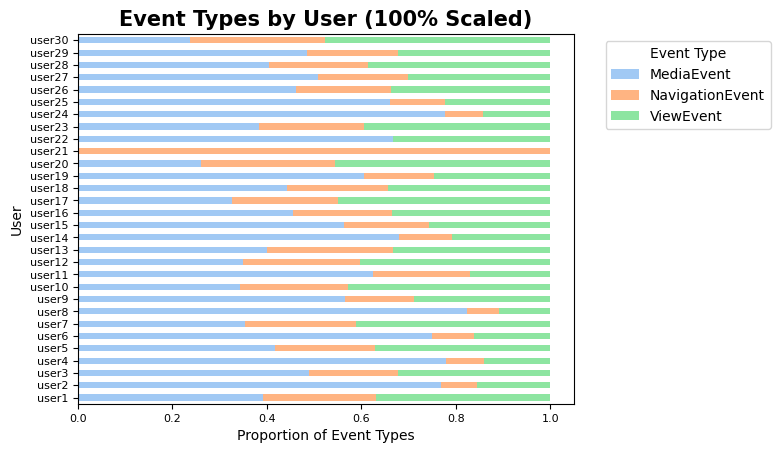

In [302]:
# 사용자 ID를 간단한 'user1', 'user2' 등의 형식으로 대체
user_mapping = {
    original_id: f"user{i+1}" for i, original_id in enumerate(df["userid"].unique())
}
df["userid_simple"] = df["userid"].map(user_mapping)

# 'userid_simple'과 'event_type'별로 데이터 집계 및 비율 계산
event_counts = df.groupby(["userid_simple", "event_type"]).size().unstack(fill_value=0)

# 각 행(사용자) 별로 100% 스케일로 비율 계산
event_counts_percentage = event_counts.div(event_counts.sum(axis=1), axis=0)

# user ID를 숫자 순서대로 정렬
event_counts_percentage_sorted = event_counts_percentage.copy()
event_counts_percentage_sorted.index = sorted(event_counts_percentage_sorted.index, key=lambda x: int(x[4:]))

# userid에 따른 이벤트 발생 비율 시각화 - 100% 스케일된 수평 막대그래프
event_counts_percentage_sorted.plot(kind="barh", stacked=True, color=sns.color_palette("pastel"))
plt.title("Event Types by User (100% Scaled)", fontsize="15", fontweight="bold")
plt.ylabel("User", fontsize="10")
plt.xlabel("Proportion of Event Types", fontsize="10")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(title="Event Type", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

In [303]:
# user 별 평균 며칠 간격으로 접속하는지

# 각 사용자에 대한 연속된 타임스탬프 간의 시간 차이 계산
df_sorted = df.sort_values(by=["userid_simple", "timestamp"])
df_sorted["prev_timestamp"] = df_sorted.groupby("userid_simple")["timestamp"].shift(1)
df_sorted["days_between"] = (
    df_sorted["timestamp"] - df_sorted["prev_timestamp"]
).dt.days

# 'prev_timestamp'이 NaN인 행(즉, 각 사용자의 첫 기록)을 필터링하여 제거
df_filtered = df_sorted.dropna(subset=["prev_timestamp"])

# 각 사용자에 대한 평균 접속일 증가 계산
days_increase = (
    df_filtered.groupby("userid_simple")["days_between"].mean().reset_index()
)

# 평균 활동 간격을 원래 데이터프레임에 days_between_mean이라는 이름으로 추가
df = df.merge(
    days_increase.rename(columns={"days_between": "days_between_mean"}),
    on="userid_simple",
    how="left",
)

# Display the updated dataframe
df.head(100)

,userid,learning_seq,mcode,learning_action_seq,event_type,action,object_type,timestamp,gender,grade,...,day_25_status,day_26_status,day_27_status,day_28_status,day_29_status,day_30_status,day_31_status,change_date,userid_simple,days_between_mean
0,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,1,ViewEvent,Viewed,DigitalResource,2022-09-14 23:28:53.150,M,5,...,44,44,44,44,44,44,999,25,user1,0.000000
1,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,2,NavigationEvent,NavigatedTo,DigitalResource,2022-09-14 23:30:09.481,M,5,...,44,44,44,44,44,44,999,25,user1,0.000000
2,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,3,ViewEvent,Viewed,DigitalResource,2022-09-14 23:30:09.604,M,5,...,44,44,44,44,44,44,999,25,user1,0.000000
3,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,4,NavigationEvent,NavigatedTo,DigitalResource,2022-09-14 23:30:43.752,M,5,...,44,44,44,44,44,44,999,25,user1,0.000000
4,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,5,ViewEvent,Viewed,DigitalResource,2022-09-14 23:30:43.883,M,5,...,44,44,44,44,44,44,999,25,user1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,076bf224-16b8-48ca-b646-752a771b1dcc,8,T0XE52U01016,1,ViewEvent,Viewed,DigitalResource,2022-09-16 19:45:13.570,M,5,...,1,1,44,44,44,44,999,27,user2,0.013115
96,076bf224-16b8-48ca-b646-752a771b1dcc,9,T0WE90U20001,1,ViewEvent,Viewed,DigitalResource,2022-09-16 19:48:39.636,M,5,...,1,1,44,44,44,44,999,27,user2,0.013115
97,076bf224-16b8-48ca-b646-752a771b1dcc,9,T0WE90U20001,2,NavigationEvent,NavigatedTo,DigitalResource,2022-09-16 19:48:44.478,M,5,...,1,1,44,44,44,44,999,27,user2,0.013115
98,076bf224-16b8-48ca-b646-752a771b1dcc,9,T0WE90U20001,10,MediaEvent,ChangedVolume,VideoObject,2022-09-16 19:48:45.191,M,5,...,1,1,44,44,44,44,999,27,user2,0.013115


<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_17592\1643317387.py:6: SyntaxWarning: invalid escape sequence '\d'
  days_increase_sorted["userid_simple"].str.extract("(\d+)").astype(int)


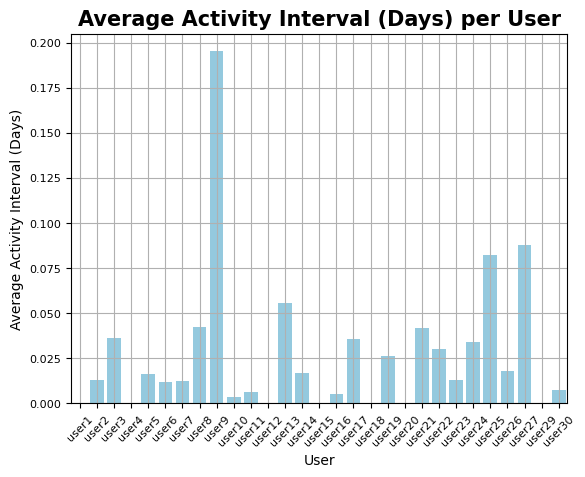

In [304]:
# 시각화

# 'userid_simple'을 바 플롯에서 올바른 순서로 표시하기 위해 정렬
days_increase_sorted = days_increase.copy()
days_increase_sorted["user_num"] = (
    days_increase_sorted["userid_simple"].str.extract("(\d+)").astype(int)
)
days_increase_sorted = days_increase_sorted.sort_values(by="user_num").drop(
    columns="user_num"
)

# 각 사용자에 대한 평균 활동일 간격 시각화
sns.barplot(
    x="userid_simple", y="days_between", data=days_increase_sorted, color="skyblue"
)

plt.title("Average Activity Interval (Days) per User", fontsize=15, fontweight="bold")
plt.xlabel("User", fontsize=10)
plt.ylabel("Average Activity Interval (Days)", fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)

plt.show()

<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_17592\3402181451.py:25: SyntaxWarning: invalid escape sequence '\d'
  user_slopes["user_num"] = user_slopes["userid_simple"].str.extract("(\d+)").astype(int)
C:\Users\user\AppData\Local\Temp\ipykernel_17592\3402181451.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["activity_order"] = df_filtered.groupby("userid_simple").cumcount() + 1
C:\Users\user\AppData\Local\Temp\ipykernel_17592\3402181451.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the op

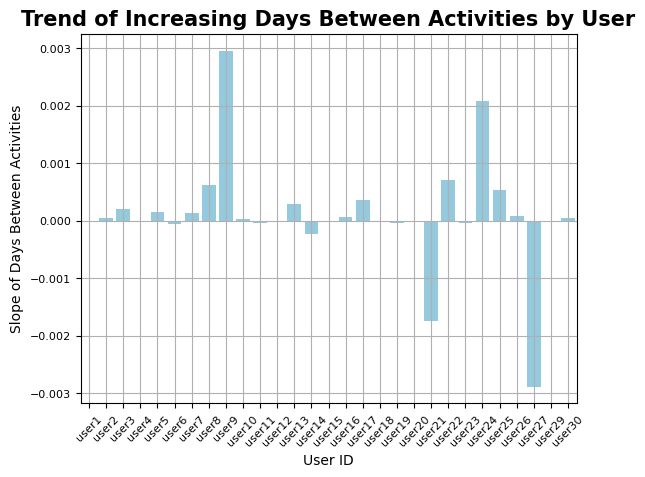

In [305]:
# 사용자별 접속일 간격 증감 추이

# 날짜 간격 계산
df_sorted = df.sort_values(by=["userid_simple", "timestamp"])
df_sorted["prev_timestamp"] = df_sorted.groupby("userid_simple")["timestamp"].shift(1)
df_sorted["days_between"] = (
    df_sorted["timestamp"] - df_sorted["prev_timestamp"]
).dt.days

# NaN 값 제거 (첫 번째 활동 기록)
df_filtered = df_sorted.dropna(subset=["prev_timestamp"])

# 접속 순서를 계산
df_filtered["activity_order"] = df_filtered.groupby("userid_simple").cumcount() + 1

# 사용자별로 접속일 간격의 기울기 계산 (np.polyfit을 이용하여 일차 회귀 기울기 계산)
user_slopes = (
    df_filtered.groupby("userid_simple")
    .apply(lambda x: np.polyfit(x["activity_order"], x["days_between"], 1)[0])
    .reset_index()
)
user_slopes.columns = ["userid_simple", "days_between_slope"]

# 사용자별로 접속일 간격의 기울기 계산 후 정렬 (user1, user2, user3 순서로)
user_slopes["user_num"] = user_slopes["userid_simple"].str.extract("(\d+)").astype(int)
user_slopes = user_slopes.sort_values(by="user_num").drop(columns="user_num")

# 기울기 값을 원래 데이터프레임에 추가
df = df.merge(user_slopes, on="userid_simple", how="left")

# 기울기 변화를 막대 그래프로 시각화
sns.barplot(
    data=user_slopes, x="userid_simple", y="days_between_slope", color="skyblue"
)

# 제목 및 라벨 설정
plt.title(
    "Trend of Increasing Days Between Activities by User",
    fontsize=15,
    fontweight="bold",
)
plt.xlabel("User ID", fontsize=10)
plt.ylabel("Slope of Days Between Activities", fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)

plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_17592\4093169888.py:9: SyntaxWarning: invalid escape sequence '\d'
  user_mcode_count["userid_simple"].str.extract("(\d+)").astype(int)


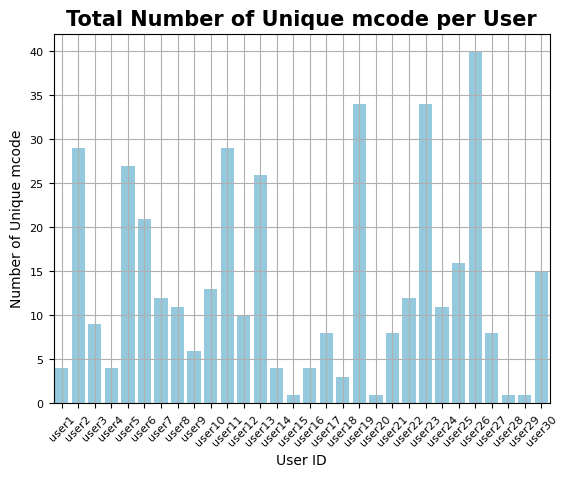

,userid,learning_seq,mcode,learning_action_seq,event_type,action,object_type,timestamp,gender,grade,...,day_27_status,day_28_status,day_29_status,day_30_status,day_31_status,change_date,userid_simple,days_between_mean,days_between_slope,mcode_count
0,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,1,ViewEvent,Viewed,DigitalResource,2022-09-14 23:28:53.150,M,5,...,44,44,44,44,999,25,user1,0.000000,0.000000,4
1,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,2,NavigationEvent,NavigatedTo,DigitalResource,2022-09-14 23:30:09.481,M,5,...,44,44,44,44,999,25,user1,0.000000,0.000000,4
2,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,3,ViewEvent,Viewed,DigitalResource,2022-09-14 23:30:09.604,M,5,...,44,44,44,44,999,25,user1,0.000000,0.000000,4
3,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,4,NavigationEvent,NavigatedTo,DigitalResource,2022-09-14 23:30:43.752,M,5,...,44,44,44,44,999,25,user1,0.000000,0.000000,4
4,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,5,ViewEvent,Viewed,DigitalResource,2022-09-14 23:30:43.883,M,5,...,44,44,44,44,999,25,user1,0.000000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,076bf224-16b8-48ca-b646-752a771b1dcc,8,T0XE52U01016,1,ViewEvent,Viewed,DigitalResource,2022-09-16 19:45:13.570,M,5,...,44,44,44,44,999,27,user2,0.013115,0.000048,29
96,076bf224-16b8-48ca-b646-752a771b1dcc,9,T0WE90U20001,1,ViewEvent,Viewed,DigitalResource,2022-09-16 19:48:39.636,M,5,...,44,44,44,44,999,27,user2,0.013115,0.000048,29
97,076bf224-16b8-48ca-b646-752a771b1dcc,9,T0WE90U20001,2,NavigationEvent,NavigatedTo,DigitalResource,2022-09-16 19:48:44.478,M,5,...,44,44,44,44,999,27,user2,0.013115,0.000048,29
98,076bf224-16b8-48ca-b646-752a771b1dcc,9,T0WE90U20001,10,MediaEvent,ChangedVolume,VideoObject,2022-09-16 19:48:45.191,M,5,...,44,44,44,44,999,27,user2,0.013115,0.000048,29


In [306]:
# user별 학습 컨텐츠 이용 총 합

# 각 사용자별 mcode의 총 개수 계산
user_mcode_count = df.groupby("userid_simple")["mcode"].nunique().reset_index()
user_mcode_count.columns = ["userid_simple", "mcode_count"]

# 사용자 ID 정렬
user_mcode_count["user_num"] = (
    user_mcode_count["userid_simple"].str.extract("(\d+)").astype(int)
)
user_mcode_count = user_mcode_count.sort_values(by="user_num").drop(columns="user_num")

# 원래 데이터프레임에 mcode 총합 컬럼 추가
df = df.merge(user_mcode_count, on="userid_simple", how="left")

# 사용자별 mcode 총 개수를 막대 그래프로 시각화
sns.barplot(data=user_mcode_count, x="userid_simple", y="mcode_count", color="skyblue")

# 제목 및 라벨 설정
plt.title("Total Number of Unique mcode per User", fontsize=15, fontweight="bold")
plt.xlabel("User ID", fontsize=10)
plt.ylabel("Number of Unique mcode", fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)

plt.show()

df.head(100)

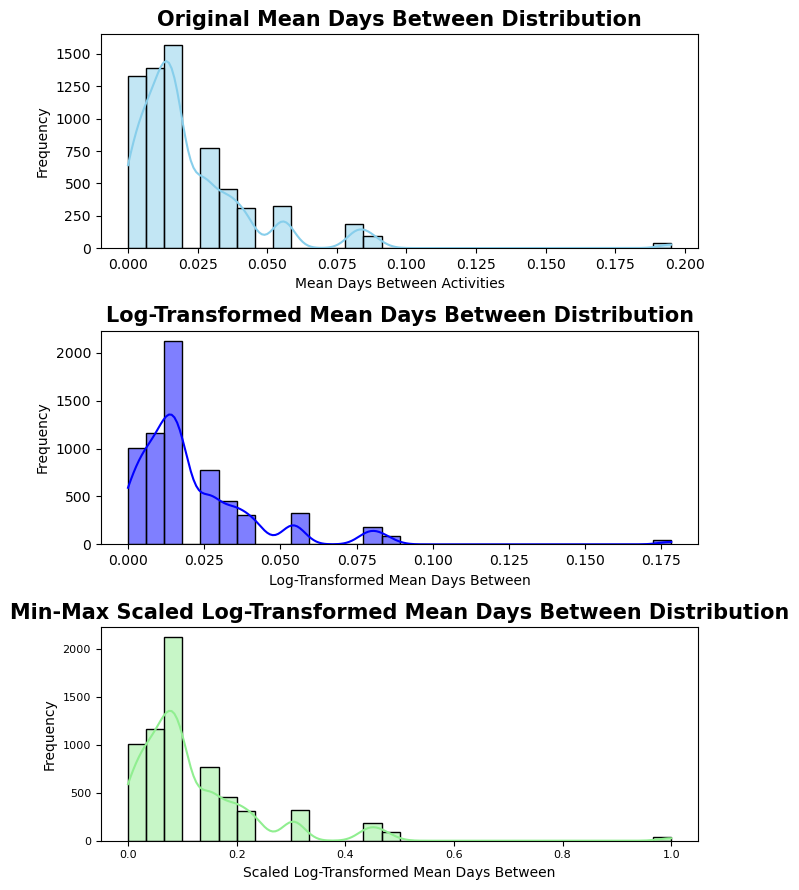

In [307]:
# 피처 days_between_mean 분포 확인(histogram) -> 로그 변환 -> minmax sacling(0~1)

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# days_between_mean에 대한 로그 변환 및 Min-Max Scaling 적용

# 로그 변환 (음수 값에 대해서는 변환 전 절대값을 취하고 부호를 유지)
df["log_days_between_mean"] = np.sign(df["days_between_mean"]) * np.log1p(
    np.abs(df["days_between_mean"])
)

# Min-Max Scaling (0-1) 적용 (로그 변환된 변수만)
df["log_mean_scaled"] = scaler.fit_transform(df[["log_days_between_mean"]])

# 시각화를 위한 서브플롯 설정
fig, axes = plt.subplots(3, 1, figsize=(7, 9))

# 원본 데이터 분포 시각화
sns.histplot(df["days_between_mean"], bins=30, ax=axes[0], color="skyblue", kde=True)
axes[0].set_title(
    "Original Mean Days Between Distribution", fontsize=15, fontweight="bold"
)
axes[0].set_xlabel("Mean Days Between Activities", fontsize=10)
axes[0].set_ylabel("Frequency", fontsize=10)

# 로그 변환 후 데이터 분포 시각화
sns.histplot(
    df["log_days_between_mean"], bins=30, ax=axes[1], color="blue", kde=True
)
axes[1].set_title(
    "Log-Transformed Mean Days Between Distribution", fontsize=15, fontweight="bold"
)
axes[1].set_xlabel("Log-Transformed Mean Days Between", fontsize=10)
axes[1].set_ylabel("Frequency", fontsize=10)

# 로그 변환된 데이터를 Min-Max Scaling 후 데이터 분포 시각화
sns.histplot(df["log_mean_scaled"], bins=30, ax=axes[2], color="lightgreen", kde=True)
axes[2].set_title(
    "Min-Max Scaled Log-Transformed Mean Days Between Distribution",
    fontsize=15,
    fontweight="bold",
)
axes[2].set_xlabel("Scaled Log-Transformed Mean Days Between", fontsize=10)
axes[2].set_ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 그래프 간의 간격을 조정하여 겹치지 않도록 함
plt.tight_layout()
plt.show()

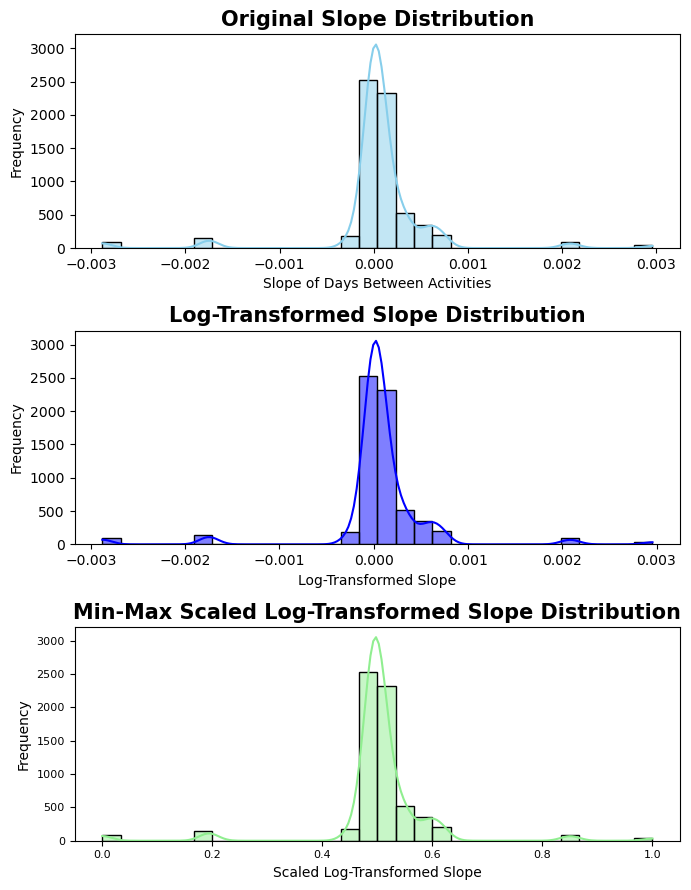

In [308]:
# 피처 days_between_slope 분포 확인(histogram) -> 로그 변환 -> minmax sacling(0~1)

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# days_between_slope에 대한 로그 변환 및 Min-Max Scaling 적용

# 로그 변환 (음수 값에 대해서는 변환 전 절대값을 취하고 부호를 유지)
df["log_days_between_slope"] = np.sign(df["days_between_slope"]) * np.log1p(
    np.abs(df["days_between_slope"])
)

# Min-Max Scaling (0-1) 적용 (로그 변환된 변수만)
df["log_slope_scaled"] = scaler.fit_transform(df[["log_days_between_slope"]])

# 시각화를 위한 서브플롯 설정
fig, axes = plt.subplots(3, 1, figsize=(7, 9))

# 원본 데이터 분포 시각화
sns.histplot(df["days_between_slope"], bins=30, ax=axes[0], color="skyblue", kde=True)
axes[0].set_title("Original Slope Distribution", fontsize=15, fontweight="bold")
axes[0].set_xlabel("Slope of Days Between Activities", fontsize=10)
axes[0].set_ylabel("Frequency", fontsize=10)

# 로그 변환 후 데이터 분포 시각화
sns.histplot(
    df["log_days_between_slope"], bins=30, ax=axes[1], color="blue", kde=True
)
axes[1].set_title("Log-Transformed Slope Distribution", fontsize=15, fontweight="bold")
axes[1].set_xlabel("Log-Transformed Slope", fontsize=10)
axes[1].set_ylabel("Frequency", fontsize=10)

# 로그 변환된 데이터를 Min-Max Scaling 후 데이터 분포 시각화
sns.histplot(df["log_slope_scaled"], bins=30, ax=axes[2], color="lightgreen", kde=True)
axes[2].set_title(
    "Min-Max Scaled Log-Transformed Slope Distribution", fontsize=15, fontweight="bold"
)
axes[2].set_xlabel("Scaled Log-Transformed Slope", fontsize=10)
axes[2].set_ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 그래프 간의 간격을 조정하여 겹치지 않도록 함
plt.tight_layout()
plt.show()

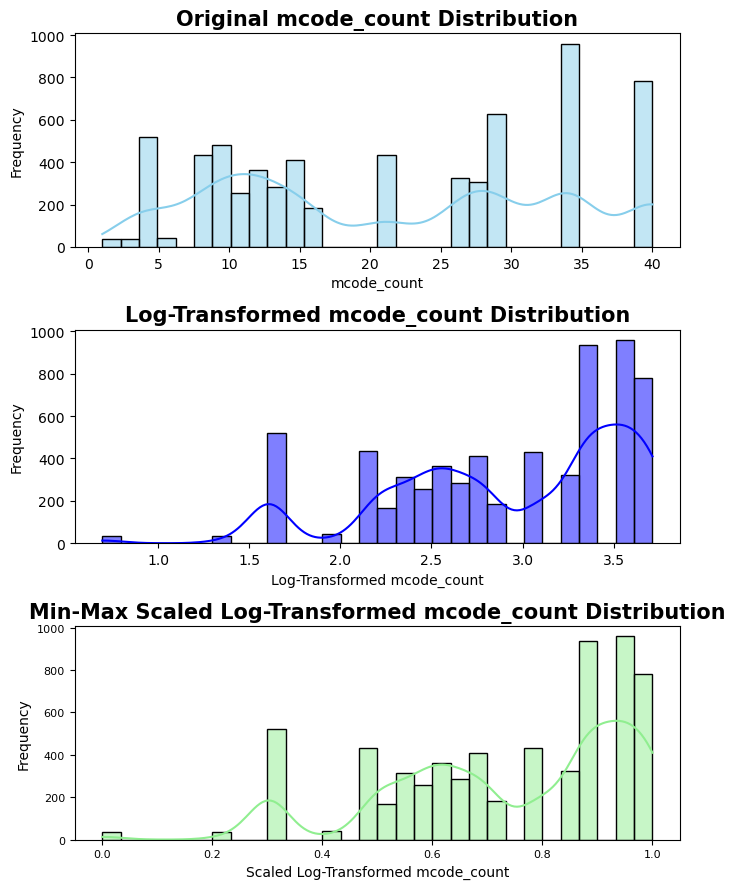

In [309]:
# 피처 mcode_count 분포 확인(histogram) -> 로그 변환 -> minmax sacling(0~1)

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# mcode_count에 대한 로그 변환 및 Min-Max Scaling 적용

# 로그 변환 (음수 값에 대해서는 변환 전 절대값을 취하고 부호를 유지)
df["log_mcode_count"] = np.sign(df["mcode_count"]) * np.log1p(np.abs(df["mcode_count"]))

# Min-Max Scaling (0-1) 적용 (로그 변환된 변수만)
df["log_mcode_scaled"] = scaler.fit_transform(df[["log_mcode_count"]])

# 시각화를 위한 서브플롯 설정
fig, axes = plt.subplots(3, 1, figsize=(7, 9))

# 원본 데이터 분포 시각화
sns.histplot(df["mcode_count"], bins=30, ax=axes[0], color="skyblue", kde=True)
axes[0].set_title("Original mcode_count Distribution", fontsize=15, fontweight="bold")
axes[0].set_xlabel("mcode_count", fontsize=10)
axes[0].set_ylabel("Frequency", fontsize=10)

# 로그 변환 후 데이터 분포 시각화
sns.histplot(df["log_mcode_count"], bins=30, ax=axes[1], color="blue", kde=True)
axes[1].set_title(
    "Log-Transformed mcode_count Distribution", fontsize=15, fontweight="bold"
)
axes[1].set_xlabel("Log-Transformed mcode_count", fontsize=10)
axes[1].set_ylabel("Frequency", fontsize=10)

# 로그 변환된 데이터를 Min-Max Scaling 후 데이터 분포 시각화
sns.histplot(df["log_mcode_scaled"], bins=30, ax=axes[2], color="lightgreen", kde=True)
axes[2].set_title(
    "Min-Max Scaled Log-Transformed mcode_count Distribution",
    fontsize=15,
    fontweight="bold",
)
axes[2].set_xlabel("Scaled Log-Transformed mcode_count", fontsize=10)
axes[2].set_ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 그래프 간의 간격을 조정하여 겹치지 않도록 함
plt.tight_layout()
plt.show()

In [310]:
df.head(3)

,userid,learning_seq,mcode,learning_action_seq,event_type,action,object_type,timestamp,gender,grade,...,userid_simple,days_between_mean,days_between_slope,mcode_count,log_days_between_mean,log_mean_scaled,log_days_between_slope,log_slope_scaled,log_mcode_count,log_mcode_scaled
0,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,1,ViewEvent,Viewed,DigitalResource,2022-09-14 23:28:53.150,M,5,...,user1,0.0,0.0,4,0.0,0.0,0.0,0.493247,1.609438,0.303365
1,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,2,NavigationEvent,NavigatedTo,DigitalResource,2022-09-14 23:30:09.481,M,5,...,user1,0.0,0.0,4,0.0,0.0,0.0,0.493247,1.609438,0.303365
2,01cf7916-eb98-4d30-8c81-dd52aa5be060,1,T0TE52U01003,3,ViewEvent,Viewed,DigitalResource,2022-09-14 23:30:09.604,M,5,...,user1,0.0,0.0,4,0.0,0.0,0.0,0.493247,1.609438,0.303365


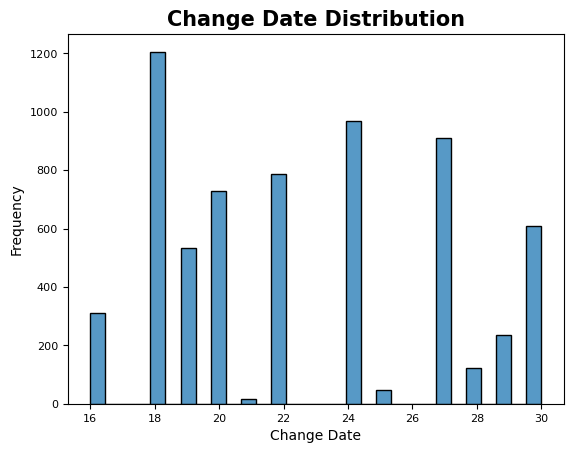

change_date
18    1206
24     968
27     911
22     788
20     729
30     609
19     532
16     312
29     234
28     124
25      46
21      17
Name: count, dtype: int64
log_mean_scaled     1
log_slope_scaled    1
log_mcode_scaled    0
dtype: int64
change_date
25    1206
27    1206
19    1206
18    1206
20    1206
29    1206
30    1206
16    1206
21    1206
28    1206
22    1206
24    1206
Name: count, dtype: int64


In [311]:
# 오버샘플링

# 'change_date'의 분포 확인
sns.histplot(df["change_date"], bins=30, kde=False)
plt.title("Change Date Distribution", fontsize=15, fontweight="bold")
plt.xlabel("Change Date", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()


# 이산형 변수로 가정하고, 클래스 분포 확인
print(df["change_date"].value_counts())

# 독립변수와 종속변수 설정
X = df[["log_mean_scaled", "log_slope_scaled", "log_mcode_scaled"]]
y = df["change_date"]

# NaN 값 확인
print(X.isna().sum())

# NaN 값 처리 (평균값으로 대체)
X = X.fillna(X.mean())

# 오버샘플링 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 오버샘플링 후의 클래스 분포 확인
print(pd.Series(y_resampled).value_counts())

Train set class distribution (sorted by class):
change_date
16     980
18     968
19     936
20     944
21     950
22     952
24     952
25     987
27     967
28    1002
29     962
30     977
Name: count, dtype: int64
Test set class distribution (sorted by class):
change_date
16    226
18    238
19    270
20    262
21    256
22    254
24    254
25    219
27    239
28    204
29    244
30    229
Name: count, dtype: int64
Mean Squared Error: 17.400150919497303
Root Mean Squared Error: 4.171348812973725
Mean Absolute Error: 3.6715224915625746
R^2 Score: 0.08413856354569704


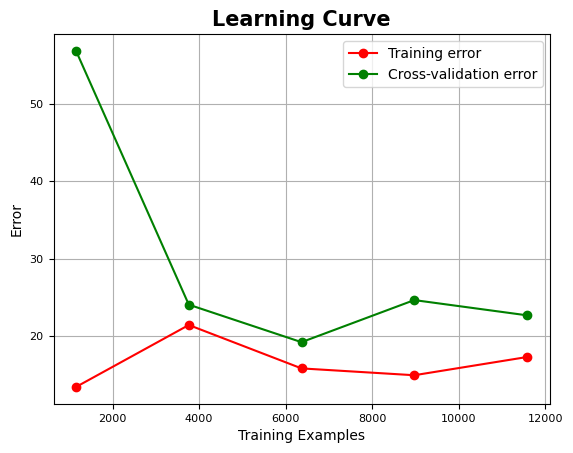

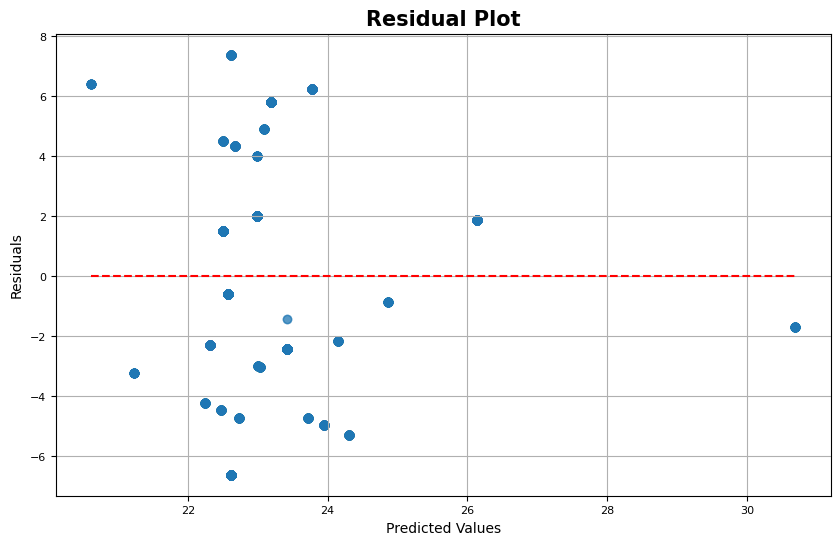

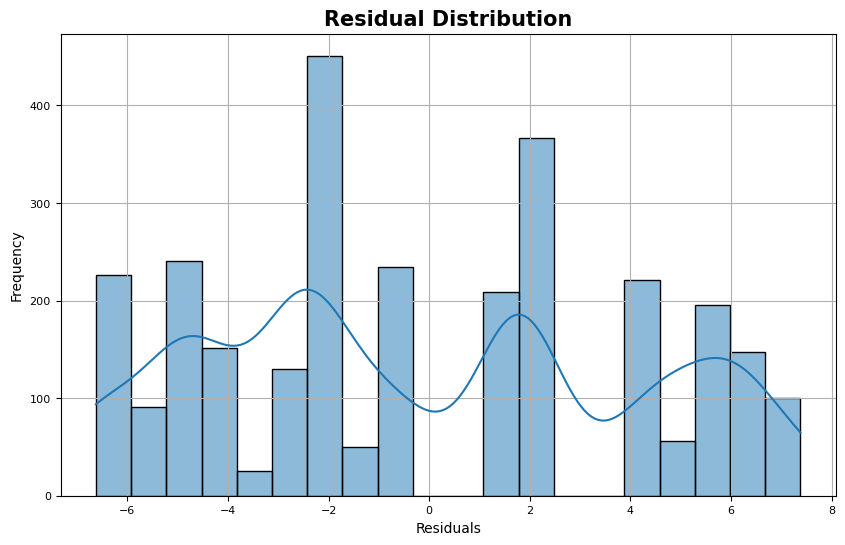

In [312]:
# 선형 회귀모델 학습

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# 트레인셋에서 클래스별 샘플 수 확인 (오름차순 정렬)
train_class_distribution = pd.Series(y_train).value_counts().sort_index()
print("Train set class distribution (sorted by class):")
print(train_class_distribution)

# 테스트셋에서 클래스별 샘플 수 확인 (오름차순 정렬)
test_class_distribution = pd.Series(y_test).value_counts().sort_index()
print("Test set class distribution (sorted by class):")
print(test_class_distribution)

# 선형 회귀 모델 초기화
linear_reg = LinearRegression()

# 모델 학습
linear_reg.fit(X_train, y_train)

# 예측
y_pred = linear_reg.predict(X_test)

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")


# 학습 곡선 (Learning Curve)
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring="neg_mean_squared_error",
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, -train_scores_mean, "o-", color="r", label="Training error")
    plt.plot(
        train_sizes, -test_scores_mean, "o-", color="g", label="Cross-validation error"
    )
    plt.xlabel("Training Examples", fontsize=10)
    plt.ylabel("Error", fontsize=10)
    plt.title("Learning Curve", fontsize=15, fontweight="bold")
    plt.legend(loc="best")
    plt.grid()
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.show()


plot_learning_curve(linear_reg, X_resampled, y_resampled)

# 잔차 플롯 (Residual Plot)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors="r", linestyles="--")
plt.xlabel("Predicted Values", fontsize=10)
plt.ylabel("Residuals", fontsize=10)
plt.title("Residual Plot", fontsize=15, fontweight="bold")
plt.grid()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

# 잔차 분포 (Residual Distribution)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.title("Residual Distribution", fontsize=15, fontweight="bold")
plt.grid()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

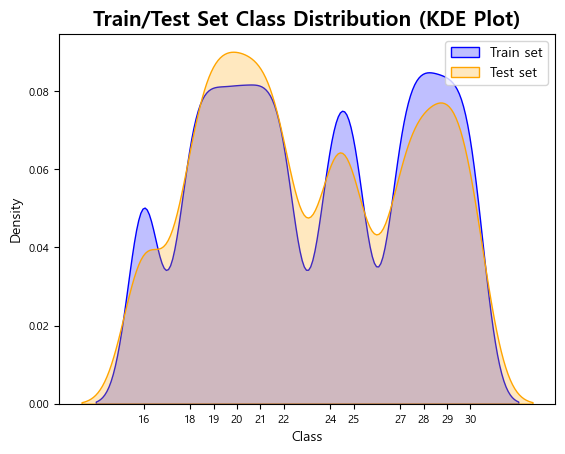

In [324]:
# Train set, Test set 분포 시각화

# Train Set과 Test Set의 클래스 분포 시각화 (KDE 플롯)

# Train Set의 KDE 플롯
sns.kdeplot(y_train, label='Train set', color='blue', fill=True)

# Test Set의 KDE 플롯
sns.kdeplot(y_test, label='Test set', color='orange', fill=True)

# x축 눈금을 이산형 값으로 설정
plt.xticks(sorted(y_train.unique()), fontsize=8)  # y_train 또는 y_test의 고유한 클래스 값 사용
plt.title('Train/Test Set Class Distribution (KDE Plot)', fontsize=15, fontweight="bold")
plt.xlabel('Class', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.yticks(fontsize=8)
plt.legend()
plt.show()

In [314]:
# 선형 회귀모델의 회귀 계수 확인; 피처 별 중요도 확인

# 회귀 계수 및 절편 출력
coefficients = linear_reg.coef_
intercept = linear_reg.intercept_

print("회귀 계수 (Coefficients):", coefficients)
print("절편 (Intercept):", intercept)

회귀 계수 (Coefficients): [ 3.83621416  7.94326988 -1.40614515]
절편 (Intercept): 19.499539607321854


Random Forest - Mean Squared Error: 0.0350941107032695
Random Forest - Root Mean Squared Error: 0.18733422192239596
Random Forest - Mean Absolute Error: 0.035840561963347374
Random Forest - R^2 Score: 0.9981528124216573


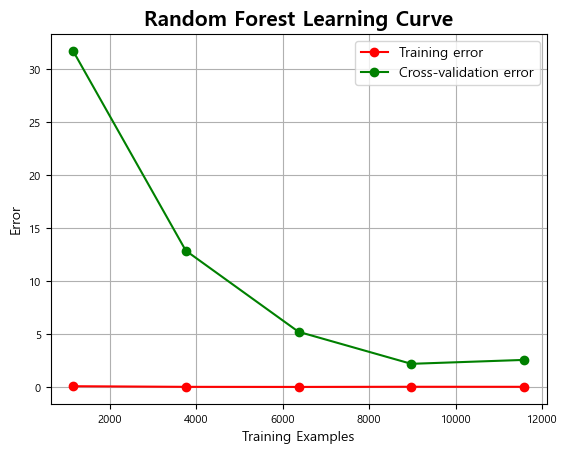

c:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


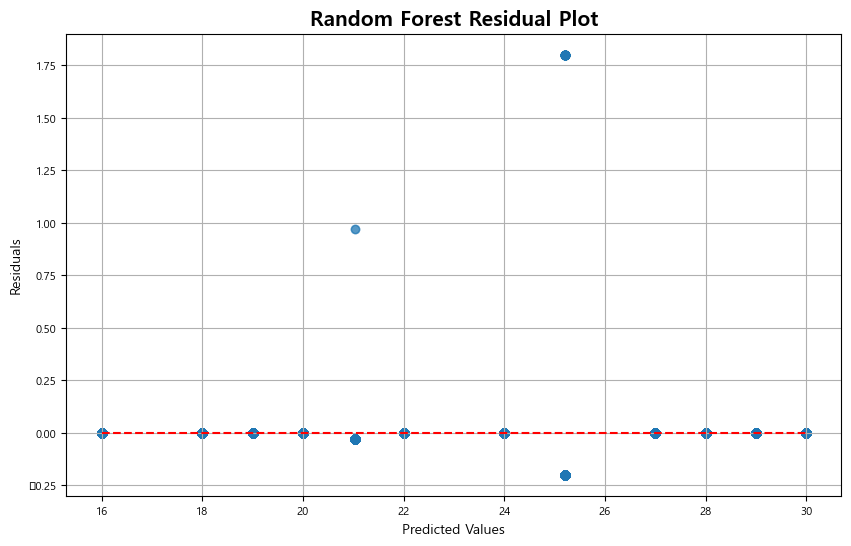

c:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


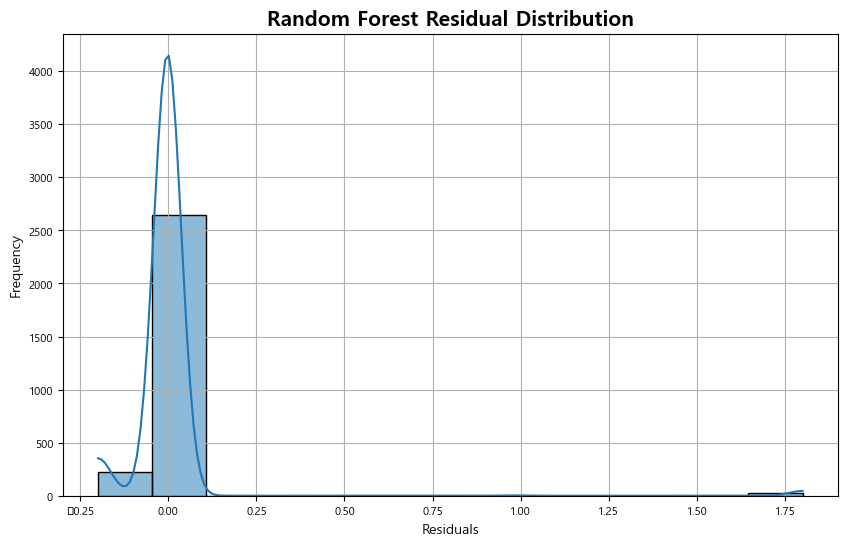

In [315]:
# 랜덤 포레스트 회귀

# 랜덤 포레스트 회귀 모델 초기화
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# 모델 학습
rf_regressor.fit(X_train, y_train)

# 예측
y_pred_rf = rf_regressor.predict(X_test)

# 성능 평가
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - Root Mean Squared Error: {rmse_rf}")
print(f"Random Forest - Mean Absolute Error: {mae_rf}")
print(f"Random Forest - R^2 Score: {r2_rf}")


# 학습 곡선 (Learning Curve)
def plot_learning_curve_rf(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring="neg_mean_squared_error",
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, -train_scores_mean, "o-", color="r", label="Training error")
    plt.plot(
        train_sizes, -test_scores_mean, "o-", color="g", label="Cross-validation error"
    )
    plt.xlabel("Training Examples", fontsize=10)
    plt.ylabel("Error", fontsize=10)
    plt.title("Random Forest Learning Curve", fontsize=15, fontweight="bold")
    plt.legend(loc="best")
    plt.grid()
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()


plot_learning_curve_rf(rf_regressor, X_resampled, y_resampled)

# 잔차 플롯 (Residual Plot)
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.5)
plt.hlines(y=0, xmin=y_pred_rf.min(), xmax=y_pred_rf.max(), colors="r", linestyles="--")
plt.xlabel("Predicted Values", fontsize=10)
plt.ylabel("Residuals", fontsize=10)
plt.title("Random Forest Residual Plot", fontsize=15, fontweight="bold")
plt.grid()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# 잔차 분포 (Residual Distribution)
plt.figure(figsize=(10, 6))
sns.histplot(residuals_rf, kde=True)
plt.xlabel("Residuals", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.title("Random Forest Residual Distribution", fontsize=15, fontweight="bold")
plt.grid()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

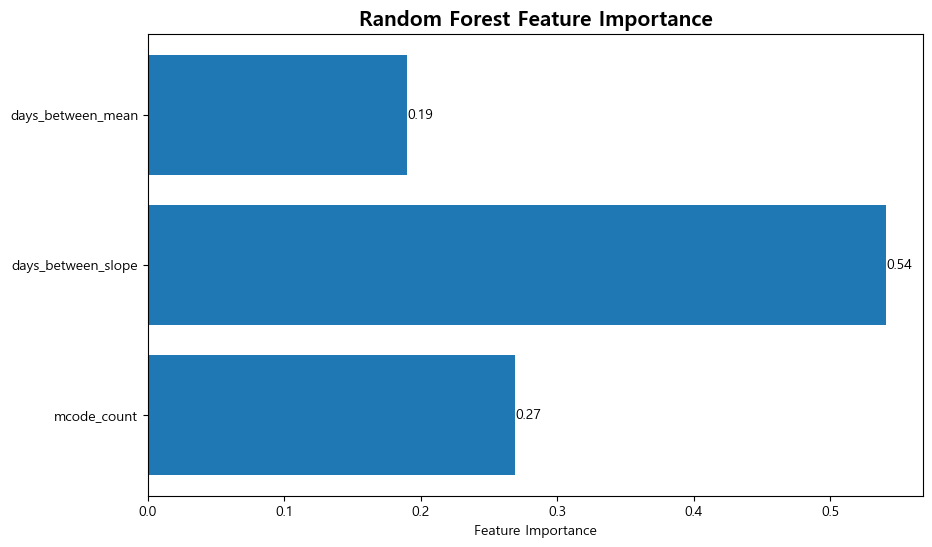

In [316]:
# 랜덤 포레스트 회귀의 feature importance 확인

# 피처 이름 리스트 (X_train의 피처가 days_between_mean, days_between_slope, mcode_count라 가정)
feature_names = ["days_between_mean", "days_between_slope", "mcode_count"]

# 피처 중요도 확인
feature_importances = rf_regressor.feature_importances_

# 피처 중요도 소숫점 셋째 자리에서 반올림
feature_importances_rounded = np.round(feature_importances, 3)

# 피처 중요도 시각화 (순서대로 표시)
plt.figure(figsize=(10, 6))
plt.barh(
    np.arange(len(feature_importances_rounded)),
    feature_importances_rounded[::-1],
    align="center",
)
plt.yticks(np.arange(len(feature_importances_rounded)), feature_names[::-1])
plt.xlabel("Feature Importance", fontsize=10)
plt.title("Random Forest Feature Importance", fontsize=15, fontweight="bold")

# 각 피처 중요도 값을 막대그래프 우측에 표시
for i in range(len(feature_importances_rounded)):
    plt.text(
        feature_importances_rounded[::-1][i],
        i,
        f"{feature_importances_rounded[::-1][i]:.2f}",
        va="center",
    )

plt.show()

SVR - Mean Squared Error: 12.273531340704896
SVR - Root Mean Squared Error: 3.5033600072936975
SVR - Mean Absolute Error: 1.5639572163054638
SVR - R^2 Score: 0.35397950879441886


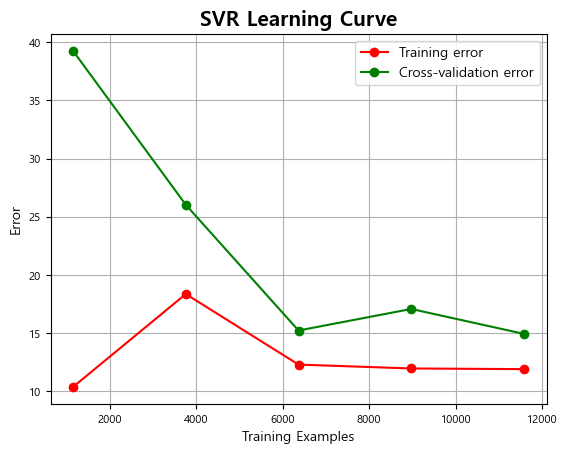

c:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


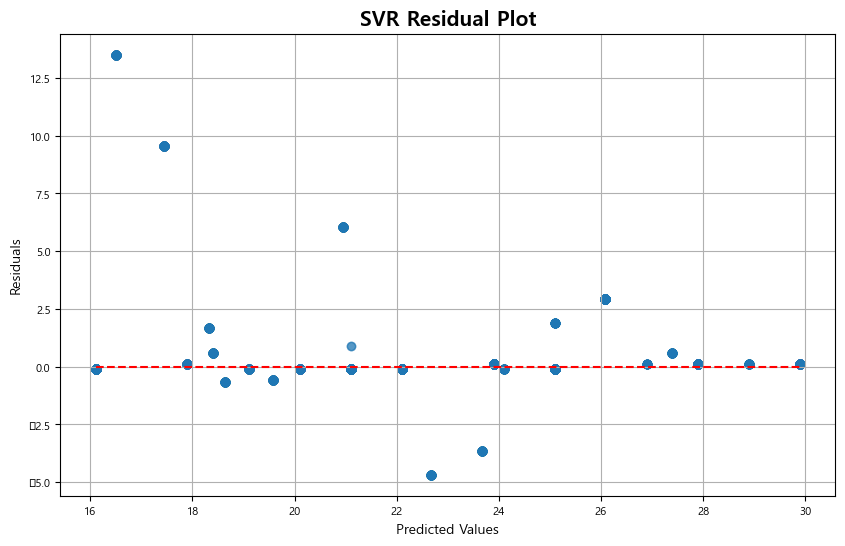

c:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


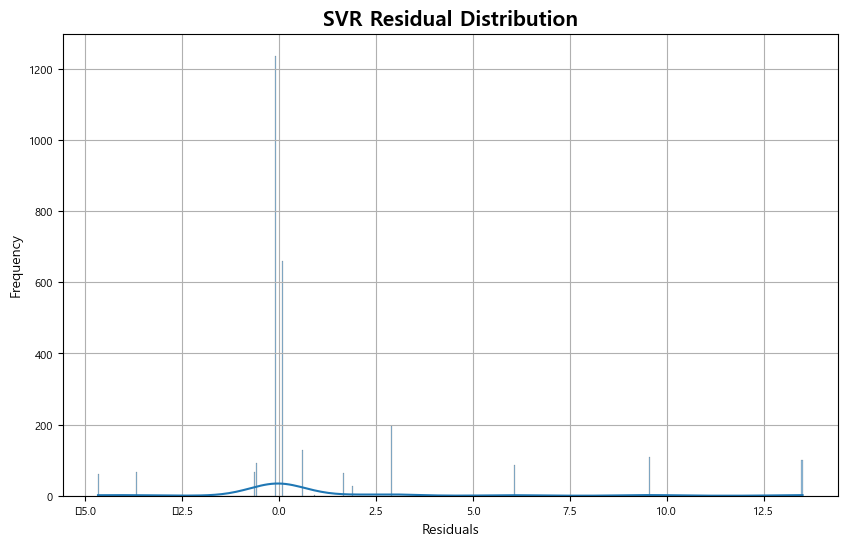

In [317]:
# 서포트 벡터 회귀

# 서포트 벡터 회귀 모델 초기화
svr_regressor = SVR(kernel="rbf", C=1.0, epsilon=0.1)

# 모델 학습
svr_regressor.fit(X_train, y_train)

# 예측
y_pred_svr = svr_regressor.predict(X_test)

# 성능 평가
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR - Mean Squared Error: {mse_svr}")
print(f"SVR - Root Mean Squared Error: {rmse_svr}")
print(f"SVR - Mean Absolute Error: {mae_svr}")
print(f"SVR - R^2 Score: {r2_svr}")


# 학습 곡선 (Learning Curve)
def plot_learning_curve_svr(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring="neg_mean_squared_error",
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, -train_scores_mean, "o-", color="r", label="Training error")
    plt.plot(
        train_sizes, -test_scores_mean, "o-", color="g", label="Cross-validation error"
    )
    plt.xlabel("Training Examples", fontsize=10)
    plt.ylabel("Error", fontsize=10)
    plt.title("SVR Learning Curve", fontsize=15, fontweight="bold")
    plt.legend(loc="best")
    plt.grid()
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()


plot_learning_curve_svr(svr_regressor, X_resampled, y_resampled)

# 잔차 플롯 (Residual Plot)
residuals_svr = y_test - y_pred_svr

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_svr, residuals_svr, alpha=0.5)
plt.hlines(
    y=0, xmin=y_pred_svr.min(), xmax=y_pred_svr.max(), colors="r", linestyles="--"
)
plt.xlabel("Predicted Values", fontsize=10)
plt.ylabel("Residuals", fontsize=10)
plt.title("SVR Residual Plot", fontsize=15, fontweight="bold")
plt.grid()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# 잔차 분포 (Residual Distribution)
plt.figure(figsize=(10, 6))
sns.histplot(residuals_svr, kde=True)
plt.xlabel("Residuals", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.title("SVR Residual Distribution", fontsize=15, fontweight="bold")
plt.grid()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

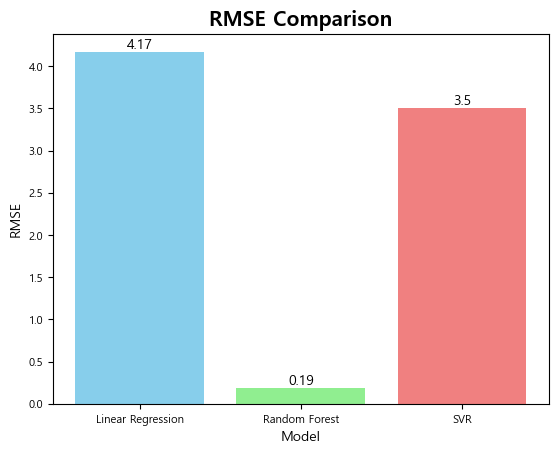

In [325]:
# 세가지 모델 성능 비교/분석

# RMSE 값과 모델 이름
rmse_values = [rmse, rmse_rf, rmse_svr]
model_names = ["Linear Regression", "Random Forest", "SVR"]

# 각각의 막대 색상을 파스텔 색상으로 설정
colors = ["skyblue", "lightgreen", "lightcoral"]

# 막대 그래프 생성
bars = plt.bar(model_names, rmse_values, color=colors)
plt.xlabel("Model", fontsize=10)
plt.ylabel("RMSE", fontsize=10)
plt.title("RMSE Comparison", fontsize=15, fontweight="bold")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 각 바 위에 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        ha="center",
        va="bottom",
    )

plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_17592\3315075537.py:37: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()


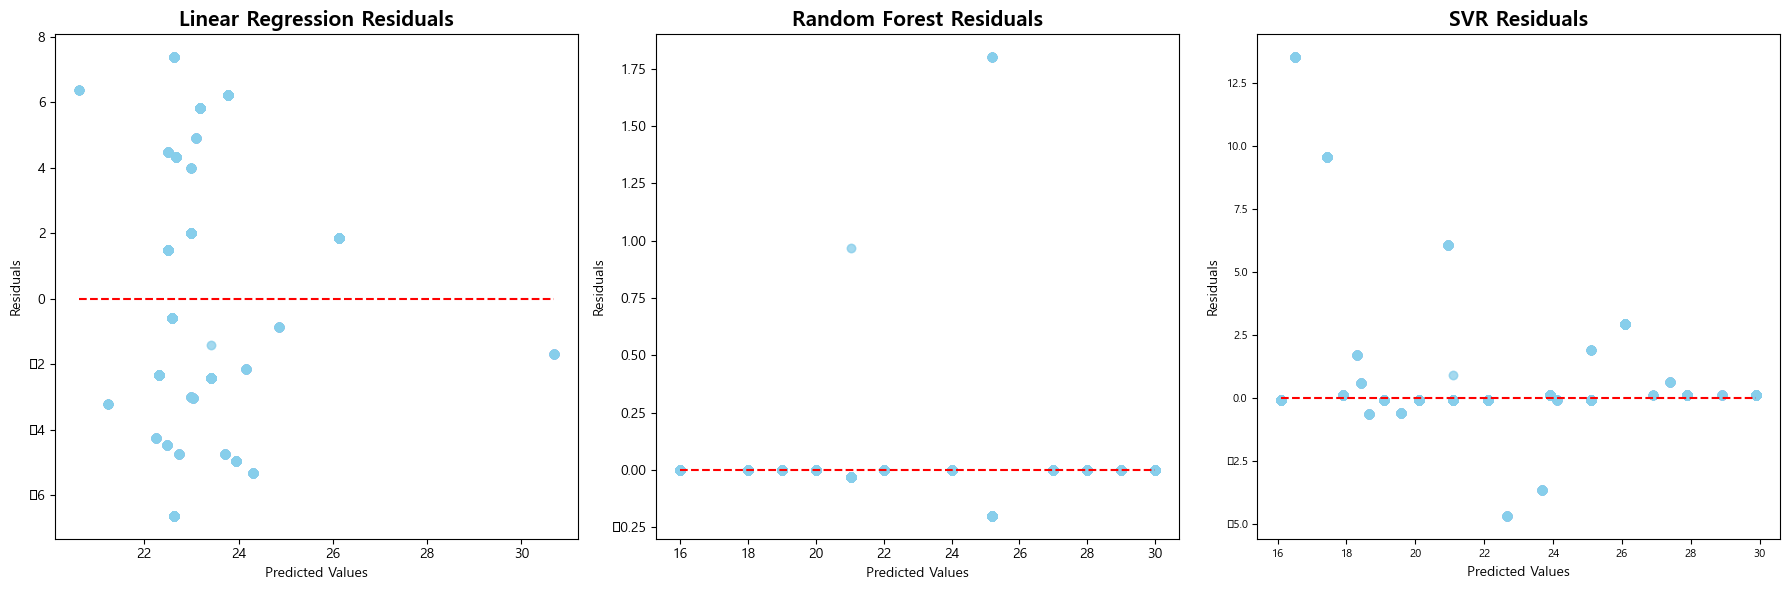

In [319]:
# 회귀 잔차 비교

# 선형 회귀 잔차
residuals_linear = y_test - y_pred
# 랜덤 포레스트 잔차
residuals_rf = y_test - y_pred_rf
# 서포트 벡터 회귀 잔차
residuals_svr = y_test - y_pred_svr

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(y_pred, residuals_linear, alpha=0.5, color="skyblue")
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors="r", linestyles="--")
plt.xlabel("Predicted Values", fontsize=10)
plt.ylabel("Residuals", fontsize=10)
plt.title("Linear Regression Residuals", fontsize=15, fontweight="bold")

plt.subplot(1, 3, 2)
plt.scatter(y_pred_rf, residuals_rf, alpha=0.5, color="skyblue")
plt.hlines(y=0, xmin=y_pred_rf.min(), xmax=y_pred_rf.max(), colors="r", linestyles="--")
plt.xlabel("Predicted Values", fontsize=10)
plt.ylabel("Residuals", fontsize=10)
plt.title("Random Forest Residuals", fontsize=15, fontweight="bold")

plt.subplot(1, 3, 3)
plt.scatter(y_pred_svr, residuals_svr, alpha=0.5, color="skyblue")
plt.hlines(
    y=0, xmin=y_pred_svr.min(), xmax=y_pred_svr.max(), colors="r", linestyles="--"
)
plt.xlabel("Predicted Values", fontsize=10)
plt.ylabel("Residuals", fontsize=10)
plt.title("SVR Residuals", fontsize=15, fontweight="bold")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_17592\1355247641.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(


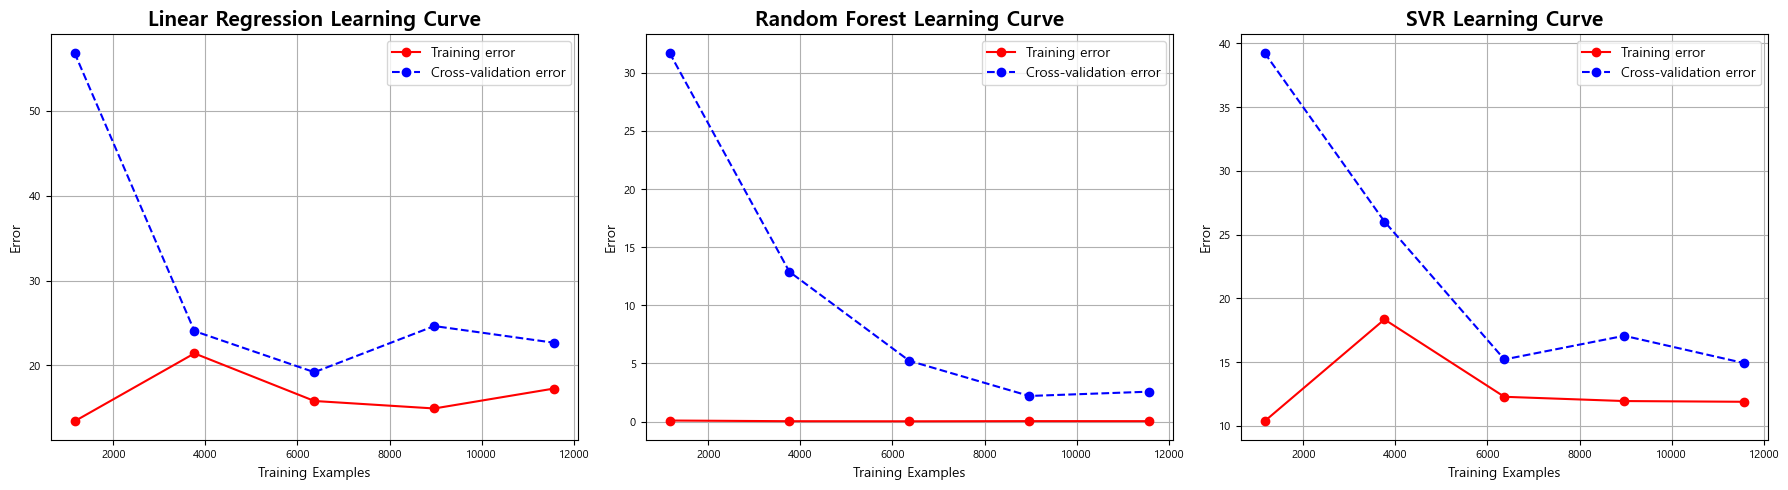

In [320]:
# 학습 곡선 비교


def plot_learning_curve_subplot(model, X, y, ax, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring="neg_mean_squared_error",
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    ax.plot(train_sizes, -train_scores_mean, "o-", color="red", label="Training error")
    ax.plot(
        train_sizes,
        -test_scores_mean,
        "o-",
        color="blue",
        linestyle="--",
        label="Cross-validation error",
    )
    ax.set_xlabel("Training Examples", fontsize=10)
    ax.set_ylabel("Error", fontsize=10)
    ax.set_title(title, fontsize=15, fontweight="bold")
    ax.legend(loc="best")
    ax.grid()
    ax.tick_params(axis="both", which="major", labelsize=8)


# 서브플롯 설정
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 각 서브플롯에 학습 곡선 그리기
plot_learning_curve_subplot(
    linear_reg,
    X_resampled,
    y_resampled,
    axes[0],
    title="Linear Regression Learning Curve",
)
plot_learning_curve_subplot(
    rf_regressor,
    X_resampled,
    y_resampled,
    axes[1],
    title="Random Forest Learning Curve",
)
plot_learning_curve_subplot(
    svr_regressor, X_resampled, y_resampled, axes[2], title="SVR Learning Curve"
)

plt.tight_layout()
plt.show()

In [321]:
"""
# 서포트 벡터 회귀의 피처 중요도 간접적 평가 : SHAP

# 데이터 샘플링 (예: 10%의 데이터만 사용); 데이터 용량이 너무 커, 분석이 이루어지지 않아 10% 샘플링
sample_size = int(0.1 * X_train.shape[0])  # 샘플링 비율 설정
X_train_sample = X_train.sample(sample_size, random_state=42)
X_test_sample = X_test.sample(sample_size, random_state=42)

# SHAP 분석
explainer = shap.KernelExplainer(svr_regressor.predict, X_train_sample)
shap_values = explainer.shap_values(X_test_sample)

# 시각화
shap.summary_plot(shap_values, X_test_sample)
"""

'\n# 서포트 벡터 회귀의 피처 중요도 간접적 평가 : SHAP\n\n# 데이터 샘플링 (예: 10%의 데이터만 사용); 데이터 용량이 너무 커, 분석이 이루어지지 않아 10% 샘플링\nsample_size = int(0.1 * X_train.shape[0])  # 샘플링 비율 설정\nX_train_sample = X_train.sample(sample_size, random_state=42)\nX_test_sample = X_test.sample(sample_size, random_state=42)\n\n# SHAP 분석\nexplainer = shap.KernelExplainer(svr_regressor.predict, X_train_sample)\nshap_values = explainer.shap_values(X_test_sample)\n\n# 시각화\nshap.summary_plot(shap_values, X_test_sample)\n'